# Net Flow Prediction: CitiBike (2023 - 2025)

In [1]:
# Imports
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

DATA_PATH = "../data/processed/citibike/*/*/data.parquet"

In [7]:
import duckdb
from pathlib import Path
import pandas as pd

# Adjust if needed
DATA_PATH = "../data/processed/citibike/*/*/data.parquet"
OUT_PATH  = "../data/processed/station_day_netflow.parquet"

Path(OUT_PATH).parent.mkdir(parents=True, exist_ok=True)

con = duckdb.connect()

query = f"""
WITH trips AS (
    SELECT
        start_station_name AS start_station,
        end_station_name AS end_station,
        date_trunc('day', started_at) AS day
    FROM read_parquet('{DATA_PATH}')
    WHERE started_at IS NOT NULL
),

-- All unique stations (from starts and ends)
stations AS (
    SELECT DISTINCT station FROM (
        SELECT start_station AS station FROM trips
        UNION
        SELECT end_station   AS station FROM trips
    )
),

-- Date bounds
bounds AS (
    SELECT
        min(day) AS min_day,
        max(day) AS max_day
    FROM trips
),

-- All days between min and max (dense)
days AS (
    SELECT
        min_day + (i || ' days')::INTERVAL AS day
    FROM bounds,
         range(date_diff('day', min_day, max_day) + 1) AS t(i)
),

-- Dense station × day grid
grid AS (
    SELECT
        s.station,
        d.day
    FROM stations s
    CROSS JOIN days d
),

-- Daily pickups per station
pickups AS (
    SELECT
        start_station AS station,
        day,
        COUNT(*) AS n_pickups
    FROM trips
    GROUP BY start_station, day
),

-- Daily dropoffs per station
dropoffs AS (
    SELECT
        end_station AS station,
        day,
        COUNT(*) AS n_dropoffs
    FROM trips
    GROUP BY end_station, day
),

-- Combine grid with pickups & dropoffs
daily_base AS (
    SELECT
        g.station AS start_station_name,
        g.day,
        COALESCE(p.n_pickups, 0)  AS n_pickups,
        COALESCE(d.n_dropoffs, 0) AS n_dropoffs,
        COALESCE(d.n_dropoffs, 0) - COALESCE(p.n_pickups, 0) AS net_flow
    FROM grid g
    LEFT JOIN pickups  p USING (station, day)
    LEFT JOIN dropoffs d USING (station, day)
),

-- Add calendar features
daily_with_time AS (
    SELECT
        start_station_name,
        CAST(day AS DATE) AS day,
        n_pickups,
        n_dropoffs,
        net_flow,
        CAST(strftime(day, '%Y') AS INTEGER) AS year,
        CAST(strftime(day, '%m') AS INTEGER) AS month,
        CAST(strftime(day, '%d') AS INTEGER) AS day_of_month,
        CAST(strftime(day, '%w') AS INTEGER) AS day_of_week,   -- 0=Sunday,...,6=Saturday
        CASE
            WHEN CAST(strftime(day, '%w') AS INTEGER) IN (0, 6) THEN 1 ELSE 0
        END AS is_weekend
    FROM daily_base
),

-- Add lag & rolling features per station (for modeling)
daily_features AS (
    SELECT
        *,
        -- 1-day lag of net flow
        LAG(net_flow, 1) OVER (
            PARTITION BY start_station_name
            ORDER BY day
        ) AS net_flow_lag_1d,

        -- 7-day lag of net flow (same station, same weekday one week ago)
        LAG(net_flow, 7) OVER (
            PARTITION BY start_station_name
            ORDER BY day
        ) AS net_flow_lag_7d,

        -- rolling mean net flow over last 7 days (excluding today)
        AVG(net_flow) OVER (
            PARTITION BY start_station_name
            ORDER BY day
            ROWS BETWEEN 7 PRECEDING AND 1 PRECEDING
        ) AS net_flow_mean_7d
    FROM daily_with_time
)

SELECT
    *
FROM daily_features
ORDER BY start_station_name, day
"""

df_netflow = con.execute(query).fetchdf()
con.close()

# Save for later reuse
df_netflow.to_parquet(OUT_PATH, index=False)

df_netflow.head()


,start_station_name,day,n_pickups,n_dropoffs,net_flow,year,month,day_of_month,day_of_week,is_weekend,net_flow_lag_1d,net_flow_lag_7d,net_flow_mean_7d
0,1 Ave & E 110 St,2022-12-28,0,0,0,2022,12,28,3,0,<NA>,<NA>,NaN
1,1 Ave & E 110 St,2022-12-29,0,0,0,2022,12,29,4,0,0,<NA>,0.0
2,1 Ave & E 110 St,2022-12-30,0,0,0,2022,12,30,5,0,0,<NA>,0.0
3,1 Ave & E 110 St,2022-12-31,0,0,0,2022,12,31,6,1,0,<NA>,0.0
4,1 Ave & E 110 St,2023-01-01,31,32,1,2023,1,1,0,1,0,<NA>,0.0


In [8]:
df_model = df_netflow.dropna(subset=["net_flow_lag_7d", "net_flow_mean_7d"]).copy()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2417976 entries, 7 to 2434376
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_station_name  object        
 1   day                 datetime64[us]
 2   n_pickups           int64         
 3   n_dropoffs          int64         
 4   net_flow            int64         
 5   year                int32         
 6   month               int32         
 7   day_of_month        int32         
 8   day_of_week         int32         
 9   is_weekend          int32         
 10  net_flow_lag_1d     Int64         
 11  net_flow_lag_7d     Int64         
 12  net_flow_mean_7d    float64       
dtypes: Int64(2), datetime64[us](1), float64(1), int32(5), int64(3), object(1)
memory usage: 216.8+ MB


In [9]:
df_model.isna().sum()

start_station_name    0
day                   0
n_pickups             0
n_dropoffs            0
net_flow              0
year                  0
month                 0
day_of_month          0
day_of_week           0
is_weekend            0
net_flow_lag_1d       0
net_flow_lag_7d       0
net_flow_mean_7d      0
dtype: int64

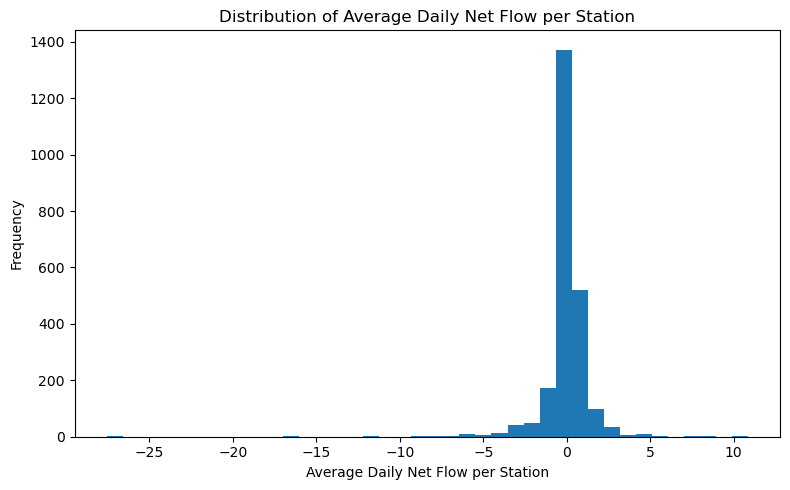

In [11]:
import matplotlib.pyplot as plt

# Compute average net flow per station
avg_netflow = df_model.groupby("start_station_name")["net_flow"].mean()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(avg_netflow, bins=40)
plt.xlabel("Average Daily Net Flow per Station")
plt.ylabel("Frequency")
plt.title("Distribution of Average Daily Net Flow per Station")
plt.tight_layout()
plt.show()


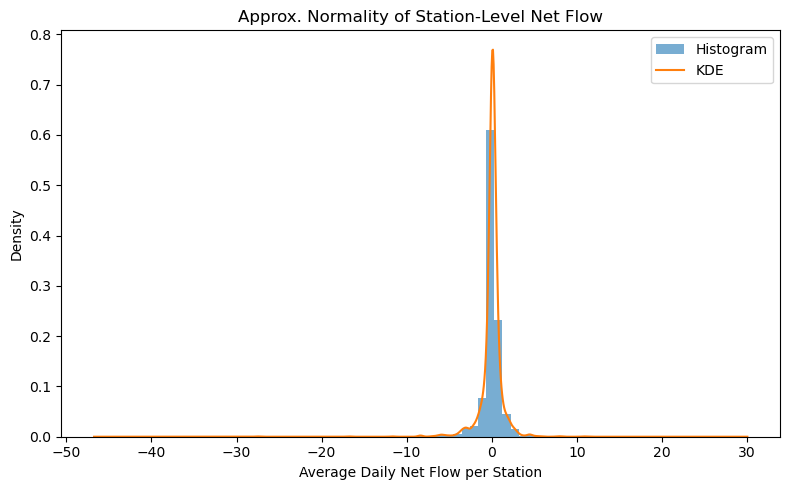

In [12]:
plt.figure(figsize=(8,5))
plt.hist(avg_netflow, bins=40, density=True, alpha=0.6, label="Histogram")
avg_netflow.plot(kind="kde", label="KDE")
plt.xlabel("Average Daily Net Flow per Station")
plt.title("Approx. Normality of Station-Level Net Flow")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
import scipy.stats as st

mean  = avg_netflow.mean()
std   = avg_netflow.std()
skew  = st.skew(avg_netflow)
kurt  = st.kurtosis(avg_netflow)

print(mean, std, skew, kurt)


7.581548610329708e-19 1.367072344599258 -5.117822166723837 89.22309352189305


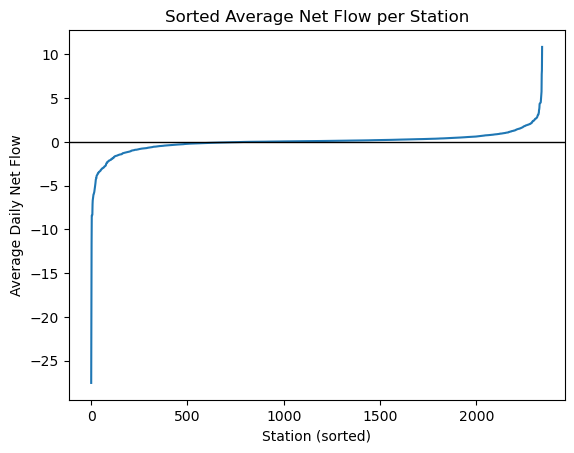

In [14]:
import numpy as np
vals = np.sort(avg_netflow.values)

plt.plot(vals)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Station (sorted)")
plt.ylabel("Average Daily Net Flow")
plt.title("Sorted Average Net Flow per Station")
plt.show()


In [17]:
import pandas as pd

# Average daily net flow per station
avg_netflow = (
    df_model
    .groupby("start_station_name", as_index=False)["net_flow"]
    .mean()
    .rename(columns={"net_flow": "avg_net_flow"})
)

# Station coords (one row per station)
station_coords = (
    df_model[["start_station_name", "start_lat", "start_lng"]]
    .drop_duplicates()
)

# Merge avg net flow with coordinates
stations_nf = avg_netflow.merge(
    station_coords, on="start_station_name", how="left"
)

# Top 20 inflow (most positive net flow)
top20_inflow = stations_nf.nlargest(20, "avg_net_flow")

# Top 20 outflow (most negative net flow)
top20_outflow = stations_nf.nsmallest(20, "avg_net_flow")


KeyError: "['start_lat', 'start_lng'] not in index"

In [19]:
import duckdb
import pandas as pd

DATA_PATH = "../data/processed/citibike/*/*/data.parquet"

con = duckdb.connect()

query = f"""
SELECT DISTINCT
    start_station_name AS station,
    AVG(start_lat) AS lat,
    AVG(start_lng) AS lng
FROM read_parquet('{DATA_PATH}')
WHERE start_lat IS NOT NULL AND start_lng IS NOT NULL
GROUP BY start_station_name
"""

station_coords = con.execute(query).fetchdf()
con.close()

station_coords.head()


,station,lat,lng
0,36 St & 4 Ave,40.654144,-74.004220
1,Lafayette Ave & St James Pl,40.688515,-73.964763
2,Ave D & E 8 St,40.723684,-73.975748
3,W 42 St & 6 Ave,40.754920,-73.984550
4,Ave A & E 14 St,40.730311,-73.980472


In [ ]:
avg_netflow = (
    df_model
    .groupby("start_station_name_clean", as_index=False)["net_flow"]
    .mean()
    .rename(columns={"net_flow": "avg_net_flow"})
)

stations_nf = avg_netflow.merge(
    station_coords,
    left_on="start_station_name_clean",
    right_on="station",
    how="left"
).drop(columns=["station"])


In [23]:
stations_nf[['lat','lng']].isna().sum()
stations_nf = stations_nf.dropna(subset=['lat','lng'])



In [24]:
top20_inflow = stations_nf.nlargest(20, "avg_net_flow")
top20_outflow = stations_nf.nsmallest(20, "avg_net_flow")
